In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.distributions import Interpolated
from scipy import stats
import pandas as pd 
import os 
#import theano.tensor as tt
# Step 1: Import Data 
# Data in this order 
# Colums of data
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("mix_hb_tcr.csv", engine = 'python')
# DATA
age = df.iloc[:,0:1]
age_err = df.iloc[:,1:2]
a40 = df.iloc[:,2:3]
a39 = df.iloc[:,3:4]
a37 = df.iloc[:,4:5]
a36 = df.iloc[:,5:6]
temp = df.iloc[:,6:7]
age = age.values
age_err = age_err.values
a40 = a40.values
a39 = a39.values
a37 = a37.values
a36 = a36.values
temp = temp.values
age = age[age >=0]
age_err = age_err[age_err !=0]
a40 = a40[a40 >= 0]
a39 = a39[a39 >= 0]
a37 = a37[a37 >= 0]
a36 = a36[a36 >= 0]
temp = temp[temp >= 0]
time= 300*np.ones(len(temp))
data = age

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
import theano 
from theano import shared, tensor as tt
ar39_err = 0.05*a39
# Cumulative sum error 
# to cast as theano shared variable then use in model 
def cumul_err(X, Y):
    zz = np.cumsum(Y)
    qq = zz/zz.max()
    
    err = np.sqrt(np.cumsum(X**2))
    z1 = err.max()
    
    y1 = np.sqrt((err/zz)**2 + (err[-1]/zz.max())**2)
    return y1

In [3]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [4]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [5]:
def fracrel(a):
    y = np.cumsum(a)
    z = y/y.max()
    return z
data2 = fracrel(a39)

# Age Spectra and Fractional Release

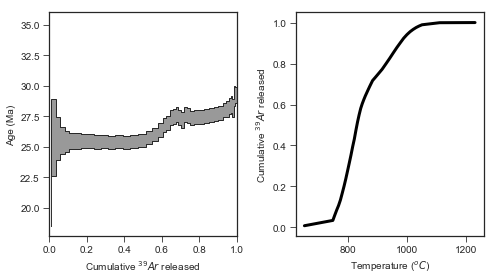

In [6]:
import seaborn as sns
sns.set_style('ticks')
fig, ax = plt.subplots(1,2, figsize = (7,4))
ax[0].fill_between(data2, data - age_err, data + age_err, 
                  step = 'pre', facecolor = 'grey', alpha = 0.8, 
                  edgecolor = 'k')
ax[0].set_xlabel('Cumulative $^{39}Ar$ released')
ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlim(0, 1)
ax[1].plot(temp, data2, lw = 3, color= 'k')
ax[1].set_ylabel('Cumulative $^{39}Ar$ released')
ax[1].set_xlabel('Temperature ($^{o}C$)')
plt.tight_layout()

In [7]:
data = age
tempk = temp + 273.15
time 
N = data.shape[0]
err_age = shared(age_err/2)

err_frel = cumul_err(ar39_err, a39)
f_err = shared(err_frel)

In [8]:
marty = pm.Model() 
with marty: 
    
    
    # Mixing/Volume Coeffs
    phi = pm.Dirichlet('phi', a = np.array([.8, .2]), 
                      testval  =[0.5,0.5], shape = 2)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential',  
                                   tt.switch(tt.min(phi) < .001, -np.inf, 0))
    # Order
    #phi_switch = pm.Potential('phi_switch', 
    #                        tt.switch(phi[0] - phi[1] < 0, - np.inf, 0))

    # Diffusion Kinetics 
    ea1 = pm.Normal('ea1', mu = 220, sd = 4, testval = 225)
    ea2 = pm.Normal('ea2', mu = 196, sd = 6, testval =  195)
    d01 = pm.Lognormal('d01', mu = 0.004, sd = 0.2)
    d02 = pm.Lognormal('d02', mu = 0.01, sd = 0.2)
    
    a1 = pm.Uniform('a1', lower= 0.001, upper = 0.0032)
    a2 = pm.Uniform('a2', lower= 0.001, upper = 0.0032)

    
    
    
    # Activation Energy Bounds
    #
    ea_bound = pm.Potential('ea_bound', 
                           tt.switch(ea1 < 210, -np.inf, 0)+ 
                           tt.switch(ea1 > 230, -np.inf, 0)) 
    #                       tt.switch(ea2 < 190, -np.inf, 0)+
    #                       tt.switch(ea2 > 200, -np.inf, 0))
    
    # Error
    #err1 = pm.HalfNormal('err1', sd = 0.08, testval = 0.002, 
    #                    shape = N)
    
    
  

In [9]:
with marty: 
    # Model 1
    m1 = phi[0]
    m2 = phi[1]
    X = fracrelx(ea1, d01, a1, tempk, time)
    Y = fracrelx(ea2, d02, a2, tempk, time)
    
    model1 = m1*X + m2*Y
    
    #Monotonicity
    
#########################
    for i in range(len(data) - 1): 
        Frel_bound = pm.Potential(f'mu_f_bound{i}', 
                                 tt.switch(model1[i +1] - model1[i] < 0, 
                                          -np.inf, 0)) 
        
    mu_f_bound = pm.Potential('mu_f_bound', tt.switch(model1 < 0, -np.inf, 0))
        
        
###############################
        
    f_err = pm.HalfNormal('f_err', 
                          sd = 0.005,
                          testval = 0.002, shape = N)    
    obs1 = pm.Normal('obs1', mu = model1, sd = f_err, 
                    observed = data2)

In [ ]:
with marty: 
    # Model 2
    A = Increment(ea1, d01, a1, tempk, time)
    B = Increment(ea2, d02, a2, tempk, time)

    age1 = pm.Normal('age1', mu = 28.72, sd = 0.5)
    age2 = pm.Normal('age2', mu = 24.59, sd = 0.5)
    
       # Ages 
    #age = pm.HalfNormal('age', sd = 1000, 
    #                shape = 2)
    #age1 = age[0]
    #age2 = age[1]
    
    model2 = ((m1*A*age1)/(m1*A + m2*B)) + ((m2*B*age2)/(m2*B + m1*A))
    
    

In [ ]:
with marty: 
    obs2 = pm.Normal('obs2', mu = model2, sd = err_age, 
                     observed = data) 

In [ ]:
#for RV in marty.basic_RVs: 
#    print(marty.name, marty.logp(marty.test_point))

In [ ]:
with marty: 
    
    step1 = pm.NUTS([age1, age2], target_accept = 0.9)
    step2 = pm.Metropolis([d01, d02, ea1, ea2,
                           a1, a2,phi, f_err])
    
    trace = pm.sample(draws = 50000, tune = 50000, 
                     step = pm.Metropolis())

In [ ]:
#pm.traceplot(trace[]); 

In [ ]:
with marty: 
    ppc = pm.sample_ppc(trace[-2000:], 200)

In [ ]:
# 95% Credible Interval 

low1, high1 = np.percentile(ppc['obs1'], [2.5, 97.5], axis = 0)
low2, high2 = np.percentile(ppc['obs2'], [2.5, 97.5], axis = 0)


In [ ]:
# Mean Predictive Models
Z1 = ppc['obs1'].mean(axis = 0)
Z2 = ppc['obs2'].mean(axis = 0)

In [ ]:
# Plotting Parameters Fonts

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8.5}

plt.rc('font', **font)
sns.set_style('ticks')

In [ ]:
# Fractional release plot
plt.figure(figsize = (5,5))
plt.fill_between(temp, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(temp, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

plt.plot(temp, data2, lw = 2, color= 'k', 
        label = 'Data')
plt.ylabel('Cumulative $^{39}$Ar released (%)')
plt.xlabel('Temperautre $^{o}$C)')
plt.legend(loc = 'best')
plt.tight_layout()

In [ ]:
# Age Spectra plot
plt.figure(figsize = (5,5))
plt.fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
plt.fill_between(data2, data - age_err, data + age_err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 'best')
plt.tight_layout()

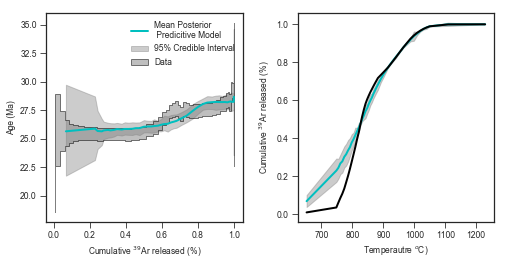

In [34]:
# Joint Summary Plots

# AGE SPECTRA
fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[0].plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax[0].fill_between(data2, data - age_err, data + age_err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best')



# Fractional Release
ax[1].fill_between(temp, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[1].plot(temp, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp, data2, lw = 2, color= 'k', 
        label = 'Data')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')



plt.tight_layout()

In [406]:
print(trace['age2'].mean(axis = 0))
print(trace['age1'].mean(axis = 0))
print(2*np.std(trace['age1']))
print(2*np.std(trace['age2']))

25.181298434112236
28.301897067463067
0.34765044020753155
0.7631892757213866


In [30]:
# Mean Posterior DataFrame
df = pd.DataFrame({"f_model": Z1, 
                  'low_bound':low1, 
                  'high_bound':high1, 
                  "age_model":Z2, 
                  "lb_age": low2, 
                  "hb_age":high2, 
                  "fel": data2, 
                  "age_data":data, 
                  "age_err": age_err, 
                  "temp": temp})

# Trace_DataFrame
df1 = pm.trace_to_dataframe(trace)

In [35]:
df.to_csv('hb_tcr_posterior.csv')
df1.to_csv('hb_tcr_trace.csv')

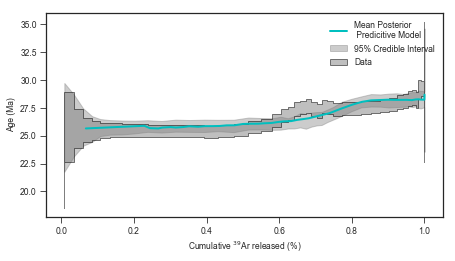

In [36]:
# AGE SPECTRA
fig, ax = plt.subplots(1,1, figsize = (7.1, 3.75))

ax.fill_between(data2, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax.plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax.fill_between(data2, data - age_err, data + age_err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

ax.set_xlabel('Cumulative $^{39}$Ar released (%)')
ax.set_ylabel('Age (Ma)')
ax.legend(loc = 'best')